# Recommendation System _ Week 7

### 정정호

### Autoencoder and Denoising autoencoder

[AutoRec: Autoencoders meet Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/2740908.2742726) \
[Keras Blog (Code)](https://blog.keras.io/building-autoencoders-in-keras.html) \
[Training Deep autoencoders for Collaborative Filtering](https://arxiv.org/pdf/1708.01715.pdf)

Reference :
- https://github.com/lumiamitie/TIL/blob/master/python/recsys_in_python_101.md 
- 김정학 "추천시스템 6주차.ipynb"

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [46]:
print(tf.__version__)

2.1.0


In [47]:
# IGNORE this part (same as haggie)
from sklearn.model_selection import train_test_split
import random

event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

articles_df = (
  pd.read_csv('./data/shared_articles.csv').loc[lambda d: d['eventType'] == 'CONTENT SHARED']  
)

interaction_df = pd.read_csv('./data/users_interactions.csv')
interaction_df['eventStrength'] = (
  interaction_df.loc[:, 'eventType'].apply(lambda d: event_type_strength[d])
)


interaction_df_over5 = (interaction_df
  .groupby('personId', group_keys=False)
  .apply(lambda df: df.assign(interactCnt = lambda d: d['contentId'].nunique()))
  .loc[lambda d: d['interactCnt'] >= 5]
)

interaction_full_df = (
  interaction_df_over5
    .groupby(['personId', 'contentId'], as_index=False)['eventStrength']
    .sum()
    .assign(eventScore = lambda d: np.log2(1+d['eventStrength']))
)

interaction_train, interaction_test = train_test_split(
    interaction_full_df,
    stratify=interaction_full_df['personId'],
    test_size=0.2,
    random_state=42
)

interaction_full_indexed = interaction_full_df.set_index('personId')
interaction_train_indexed = interaction_train.set_index('personId')
interaction_test_indexed = interaction_test.set_index('personId')

# Data Preprocessing

In [48]:
articles = pd.read_csv("./data/shared_articles.csv")
user_int = pd.read_csv("./data/users_interactions.csv")

In [49]:
articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [50]:
user_int.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


#### Columns to be used for CF in users_interaction.csv: [eventType, contentId, personId]

In [51]:
users = user_int[["eventType","contentId","personId"]].copy()

In [52]:
users.head()

,eventType,contentId,personId
0,VIEW,-3499919498720038879,-8845298781299428018
1,VIEW,8890720798209849691,-1032019229384696495
2,VIEW,310515487419366995,-1130272294246983140
3,FOLLOW,310515487419366995,344280948527967603
4,VIEW,-7820640624231356730,-445337111692715325


#### New column "interaction" containing eventType data converted to corresponding weights

In [53]:
users['interaction'] = (
  users.loc[:, 'eventType'].apply(lambda d: event_type_strength[d])
)

users

,eventType,contentId,personId,interaction
0,VIEW,-3499919498720038879,-8845298781299428018,1.0
1,VIEW,8890720798209849691,-1032019229384696495,1.0
2,VIEW,310515487419366995,-1130272294246983140,1.0
3,FOLLOW,310515487419366995,344280948527967603,3.0
4,VIEW,-7820640624231356730,-445337111692715325,1.0
...,...,...,...,...
72307,LIKE,-6590819806697898649,-9016528795238256703,2.0
72308,VIEW,-5813211845057621660,102305705598210278,1.0
72309,VIEW,-1999468346928419252,-9196668942822132778,1.0
72310,VIEW,-6590819806697898649,-9016528795238256703,1.0


In [54]:
users = (users
  .groupby('personId', group_keys=False)
  .apply(lambda df: df.assign(interactCnt = lambda d: d['contentId'].nunique()))
  .loc[lambda d: d['interactCnt'] >= 5]
)

users = (
  users
    .groupby(['personId', 'contentId'], as_index=False)['interaction']
    .sum()
    .assign(eventScore = lambda d: np.log2(1+d['interaction']))
)

users.head()

,personId,contentId,interaction,eventScore
0,-9223121837663643404,-8949113594875411859,1.0,1.000000
1,-9223121837663643404,-8377626164558006982,1.0,1.000000
2,-9223121837663643404,-8208801367848627943,1.0,1.000000
3,-9223121837663643404,-8187220755213888616,1.0,1.000000
4,-9223121837663643404,-7423191370472335463,8.0,3.169925


In [55]:
users.describe()

,personId,contentId,interaction,eventScore
count,3.910600e+04,3.910600e+04,39106.000000,39106.000000
mean,-3.550552e+16,-4.828865e+16,2.214954,1.464719
std,5.107185e+18,5.373235e+18,2.834373,0.686355
min,-9.223122e+18,-9.222795e+18,1.000000,1.000000
25%,-3.954277e+18,-4.754224e+18,1.000000,1.000000
50%,-7.450732e+16,-5.924996e+15,1.000000,1.000000
75%,3.829785e+18,4.562045e+18,2.000000,1.584963
max,9.210531e+18,9.222265e+18,230.000000,7.851749


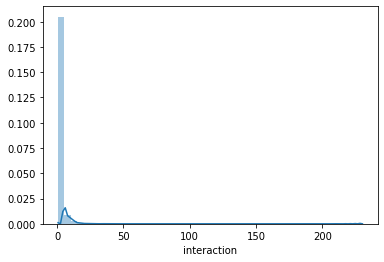

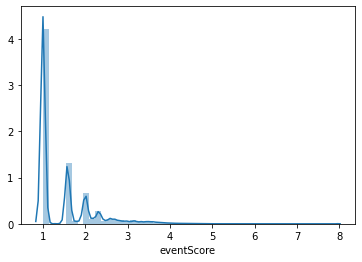

In [56]:
sns.distplot(users["interaction"])
plt.show()

sns.distplot(users["eventScore"])
plt.show()

In [57]:
# Map personId and contentId into more readable format
from sklearn.preprocessing import LabelEncoder
# access original personId by user_enc[encoded_label] (eg. user_enc.classes_[userId_enc] == users["personId"])

user_enc = LabelEncoder()
user_enc.fit(users["personId"])
userId_enc = user_enc.transform(users["personId"])

item_enc = LabelEncoder()
item_enc.fit(users["contentId"])
itemId_enc = item_enc.transform(users["contentId"])

In [58]:
users_data_enc = pd.concat([pd.Series(userId_enc), pd.Series(itemId_enc), users["eventScore"]], axis = 1)
users_data_enc.columns = ["userId","itemId","interaction"]

#### Make a user-item interaction matrix

In [59]:
interaction_matrix = users_data_enc.pivot(index = 'userId', columns = 'itemId', values = "interaction")

In [60]:
interaction_matrix.head()

itemId,0,1,2,3,4,5,6,7,8,9,...,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983
userId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
interaction_matrix.shape

(1140, 2984)

In [62]:
# Sparsity

print("Sparsity: ", interaction_matrix.isnull().sum().sum() / (interaction_matrix.size) )

Sparsity:  0.9885041860683881


In [63]:
from sklearn.preprocessing import Normalizer
IMdata = Normalizer().fit_transform(interaction_matrix.fillna(0))

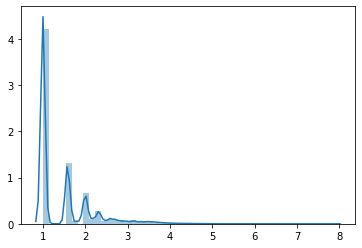

In [64]:
sns.distplot(interaction_matrix.fillna(0)[interaction_matrix.fillna(0)!=0])
plt.show()

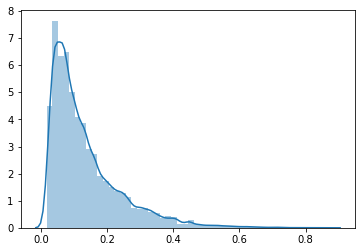

In [65]:
sns.distplot(IMdata[IMdata!=0])
plt.show()

# Model Evaluator

In [66]:
def get_items_interacted(person_id, interaction_df):
    interated_items = interaction_df.loc[person_id]['contentId']
    # else below here is for single value
    return set(interated_items if type(interated_items) == pd.Series else [interated_items])

In [67]:
class ModelEvaluator:
    def __init__(self, n_non_interacted=100):
        
        # get 100 non interacted
        
        self.EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = n_non_interacted
        
    def get_non_interacted_items_sample(self, person_id, sample_size, seed=42):
        
        # on the whole data  "full"
        
        interacted_items = get_items_interacted(person_id, interaction_full_indexed)
        all_items = set(articles_df['contentId'])
        
        non_interacted_items = all_items - interacted_items
        
        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        
        # get non interacted sample (sample_size)
        
        return set(non_interacted_items_sample)
        
    def _verify_hit_top_n(self, item_id, recommend_items, topn):

        try:
            index = next(i for i, c in enumerate(recommend_items) if c == item_id)
        except:
            index = -1
            
        hit = int(index in range(0, topn))
        return hit, index
    
    def evaluate_model_for_user(self, model, person_id):
        interacted_values_testset = interaction_test_indexed.loc[person_id]
        
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            # for single value
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])
        
        # number of items interacted by user
        interacted_items_count_testset = len(person_interacted_items_testset)
        
        # 특정 사용자에 대한 추천 순위 목록을 받아온다
        person_recs = model.recommend_items(
            person_id,
            items_to_ignore=get_items_interacted(person_id, interaction_train_indexed),
            topn=10000000000
        )
        
        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # test셋에서 사용자가 상호작용한 모든 항목에 대해 반복한다
        for item_id in person_interacted_items_testset:
            
            # 사용자가 상호작용하지 않은 100개 항목을 샘플링한다
            non_interacted_items_sample = self.get_non_interacted_items_sample(
                person_id,
                sample_size=self.EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                seed=item_id % (2**32)
            )
            
            # 현재 선택한 item_id(상호작용 있었던 항목)와 100개 랜덤 샘플을 합친다
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            
            # 추천 결과물 중에서 현재 선택한 item_id와 100개 랜덤 샘플의 결과물로만 필터링한다
            valid_recs = person_recs[person_recs.isin(items_to_filter_recs)].values
            #valid_recs = valid_recs_df['contentId'].values
            
            # 현재 선택한 item_id가 Top-N 추천 결과 안에 있는지 확인한다
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            
        # Recall 값은 상호작용 있었던 항목들 중에서 관련없는 항목들과 섞였을 때 Top-N에 오른 항목들의 비율로 나타낼 수 있다
        recall_at_5 = hits_at_5_count / interacted_items_count_testset
        recall_at_10 = hits_at_10_count / interacted_items_count_testset
        
        person_metrics = {
            'hits@5_count': hits_at_5_count,
            'hits@10_count': hits_at_10_count,
            'interacted_count': interacted_items_count_testset,
            'recall@5': recall_at_5,
            'recall@10': recall_at_10
        }
        return person_metrics
    
    def evaluate_model(self, model):
        people_metrics = []
        for idx, person_id in enumerate(list(interaction_test_indexed.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)

        print('{} users processed'.format(idx))
        
        detailed_result = (
            pd.DataFrame(people_metrics)
              .sort_values('interacted_count', ascending=False)
        )
        
        global_recall_at_5 = detailed_result['hits@5_count'].sum() / detailed_result['interacted_count'].sum()
        global_recall_at_10 = detailed_result['hits@10_count'].sum() / detailed_result['interacted_count'].sum()
        
        global_metrics = {
            'model_name': model.get_model_name(),
            'recall@5': global_recall_at_5,
            'recall@10': global_recall_at_10
        }
        
        return global_metrics, detailed_result

In [68]:
class Model:
    def __init__(self, model, user_enc, items_enc, interaction_matrix):
        self.model_name = model
        self.model = eval(model)
        self.user_enc = user_enc
        self.items_enc = items_enc
        self.interaction_matrix = interaction_matrix
        
    def get_model_name(self):
        return self.model_name
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10,verbose=False):
        user_id_enc = user_enc.transform([user_id])
        user_vec = self.interaction_matrix.iloc[user_id_enc[0],:]
        pred_list = self.model.predict([user_vec.tolist()])
        
        return pd.Series(self.items_enc.classes_[np.argsort(pred_list)[::-1]][0][:topn])

In [69]:
model_evaluator = ModelEvaluator(n_non_interacted = 100)

# Autoencoder

* Make recommendation to existing users
* Make recommendation to new users

In [70]:
from tensorflow.keras import regularizers

# train_data = interaction_matrix.fillna(0)
# train_data = train_data.apply(lambda x: [1. if i != 0. else 0 for i in x])

AEmodel = tf.keras.Sequential()

input_dim = train_data.shape[1]  #(1140, 2984)

#model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = 500))

AEmodel.add(tf.keras.layers.Dense(units = 1024, input_dim = input_dim,
                                 activity_regularizer=regularizers.l1(10e-4)))

#AEmodel.add(tf.keras.layers.Dense(units = 512))

#AEmodel.add(tf.keras.layers.Dropout(0.1))

#AEmodel.add(tf.keras.layers.Dense(units = 1024, input_dim = input_dim))

AEmodel.add(tf.keras.layers.Dense(units = input_dim, activation = 'sigmoid'))

In [71]:
import tensorflow.keras.backend as K

def custom_loss():

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        y_PRED = y_pred[(y_true != 0)]
        y_TRUE = y_true[(y_true != 0)]
        return K.mean(K.square(y_PRED - y_TRUE))
   
    # Return a function
    return loss

AEmodel.compile(loss = custom_loss(),optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics = ["accuracy"])

In [72]:
AEmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              3056640   
_________________________________________________________________
dense_5 (Dense)              (None, 2984)              3058600   
Total params: 6,115,240
Trainable params: 6,115,240
Non-trainable params: 0
_________________________________________________________________


In [73]:
AEmodel.fit(IMdata, IMdata, epochs = 20, batch_size = 100, validation_split = 0.333,
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")])

Train on 760 samples, validate on 380 samples
Epoch 1/20
760/760 [==============================] - 1s 1ms/sample - loss: 0.1624 - accuracy: 0.0000e+00 - val_loss: 0.1491 - val_accuracy: 0.0000e+00
Epoch 2/20
760/760 [==============================] - 0s 625us/sample - loss: 0.1500 - accuracy: 0.0000e+00 - val_loss: 0.1352 - val_accuracy: 0.0000e+00
Epoch 3/20
760/760 [==============================] - 0s 584us/sample - loss: 0.1202 - accuracy: 0.0000e+00 - val_loss: 0.1003 - val_accuracy: 0.0000e+00
Epoch 4/20
760/760 [==============================] - 0s 589us/sample - loss: 0.0786 - accuracy: 0.0000e+00 - val_loss: 0.0699 - val_accuracy: 0.0000e+00
Epoch 5/20
760/760 [==============================] - 0s 597us/sample - loss: 0.0573 - accuracy: 0.0000e+00 - val_loss: 0.0583 - val_accuracy: 0.0000e+00
Epoch 6/20
760/760 [==============================] - 0s 638us/sample - loss: 0.0486 - accuracy: 0.0000e+00 - val_loss: 0.0524 - val_accuracy: 0.0000e+00
Epoch 7/20
760/760 [============

In [74]:
AEmodel.predict(IMdata[0,:].reshape(-1,IMdata.shape[1]))

array([[0.31324464, 0.29687852, 0.22925583, ..., 0.30024064, 0.20412451,
        0.25643033]], dtype=float32)

In [75]:
IMdata_df = pd.DataFrame(IMdata, columns = interaction_matrix.columns, index = interaction_matrix.index)
autoencoder_model = Model("AEmodel", user_enc, item_enc, IMdata_df)

In [76]:
print('{} 추천 모형을 평가합니다'.format(autoencoder_model.get_model_name()))
pop_global_metrics, pop_detailed_results = model_evaluator.evaluate_model(autoencoder_model)
print('Global Metrics:\n{}'.format(pop_global_metrics))
pop_detailed_results.head(10)

AEmodel 추천 모형을 평가합니다
1139 users processed
Global Metrics:
{'model_name': 'AEmodel', 'recall@5': 0.2416261825620046, 'recall@10': 0.3667859882383022}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,13,37,192,0.067708,0.192708,3609194402293569455
17,7,12,134,0.052239,0.089552,-2626634673110551643
16,9,13,130,0.069231,0.100000,-1032019229384696495
10,3,4,117,0.025641,0.034188,-1443636648652872475
82,17,32,88,0.193182,0.363636,-2979881261169775358
161,9,12,80,0.112500,0.150000,-3596626804281480007
65,20,30,73,0.273973,0.410959,1116121227607581999
81,8,13,69,0.115942,0.188406,692689608292948411
106,7,17,69,0.101449,0.246377,-9016528795238256703
52,10,21,68,0.147059,0.308824,3636910968448833585


# Denoising Autoencoder

In [77]:
import random
import copy

# data masking (set random positions in the data to 0)

def mask_data(X, N, method = "2D"):
    
    assert isinstance(X, np.ndarray), 'Wrong input type for X'
    
    if method == "1D":
        row = np.where(X != 0)[0]
        pos = row.tolist()
        n = random.randint(1,N)
        mask_index = np.array(random.sample(pos, n))
        masked = np.copy(X)
        masked[mask_index] = 0
        return masked, mask_index
    
    elif method == "2D":
        
        row, col = np.where(X != 0)
        pos = [*zip(row.tolist(), col.tolist())]
        mask_index = np.array(random.sample(pos, N))
        masked = np.copy(X)
        masked[mask_index[:,0], mask_index[:,1]] = 0
    
        return masked, mask_index

In [78]:
# masking at random < 5
masking = lambda x: mask_data(x, 5, method = "1D")
train_masked = np.vstack(np.apply_along_axis(masking, 1, IMdata)[:,0])
masked_index = np.apply_along_axis(masking, 1, IMdata)[:,1]

In [79]:
DAEmodel = tf.keras.Sequential()

input_dim = train_data.shape[1]  #(1140, 2984)

#model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = 500))

DAEmodel.add(tf.keras.layers.Dense(units = 1024, input_dim = input_dim,
                                 activity_regularizer=regularizers.l1(10e-4)))

#DAEmodel.add(tf.keras.layers.Dense(units = 512, input_dim = input_dim))

#model.add(tf.keras.layers.Dropout(0.5))

#DAEmodel.add(tf.keras.layers.Dense(units = 1024, input_dim = input_dim))

DAEmodel.add(tf.keras.layers.Dense(units = input_dim, activation='sigmoid'))

DAEmodel.compile(loss = custom_loss(), optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics = ["accuracy"])

In [80]:
DAEmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              3056640   
_________________________________________________________________
dense_7 (Dense)              (None, 2984)              3058600   
Total params: 6,115,240
Trainable params: 6,115,240
Non-trainable params: 0
_________________________________________________________________


In [81]:
DAEmodel.fit(train_masked, IMdata, epochs = 10, batch_size = 150, validation_split = 0.333,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss")])

Train on 760 samples, validate on 380 samples
Epoch 1/10
760/760 [==============================] - 1s 1ms/sample - loss: 0.1615 - accuracy: 0.0000e+00 - val_loss: 0.1492 - val_accuracy: 0.0000e+00
Epoch 2/10
760/760 [==============================] - 0s 538us/sample - loss: 0.1546 - accuracy: 0.0000e+00 - val_loss: 0.1421 - val_accuracy: 0.0000e+00
Epoch 3/10
760/760 [==============================] - 0s 525us/sample - loss: 0.1396 - accuracy: 0.0000e+00 - val_loss: 0.1254 - val_accuracy: 0.0000e+00
Epoch 4/10
760/760 [==============================] - 0s 544us/sample - loss: 0.1133 - accuracy: 0.0013 - val_loss: 0.0971 - val_accuracy: 0.0000e+00
Epoch 5/10
760/760 [==============================] - 0s 531us/sample - loss: 0.0811 - accuracy: 0.0026 - val_loss: 0.0722 - val_accuracy: 0.0000e+00
Epoch 6/10
760/760 [==============================] - 0s 538us/sample - loss: 0.0604 - accuracy: 0.0026 - val_loss: 0.0602 - val_accuracy: 0.0000e+00
Epoch 7/10
760/760 [========================

In [82]:
DAEmodel.predict(train_data[0,:].reshape(-1,train_data.shape[1]))

array([[0.43149537, 0.43140766, 0.38232175, ..., 0.40681782, 0.3957355 ,
        0.41745102]], dtype=float32)

In [83]:
autoencoder_model = Model("DAEmodel", user_enc, item_enc, IMdata_df)

In [84]:
print('{} 추천 모형을 평가합니다'.format(autoencoder_model.get_model_name()))
pop_global_metrics, pop_detailed_results = model_evaluator.evaluate_model(autoencoder_model)
print('Global Metrics:\n{}'.format(pop_global_metrics))
pop_detailed_results.head(10)

DAEmodel 추천 모형을 평가합니다
1139 users processed
Global Metrics:
{'model_name': 'DAEmodel', 'recall@5': 0.28982357453336743, 'recall@10': 0.4239324980823319}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,26,51,192,0.135417,0.265625,3609194402293569455
17,13,22,134,0.097015,0.164179,-2626634673110551643
16,15,26,130,0.115385,0.200000,-1032019229384696495
10,6,11,117,0.051282,0.094017,-1443636648652872475
82,29,51,88,0.329545,0.579545,-2979881261169775358
161,14,16,80,0.175000,0.200000,-3596626804281480007
65,25,34,73,0.342466,0.465753,1116121227607581999
81,12,21,69,0.173913,0.304348,692689608292948411
106,11,23,69,0.159420,0.333333,-9016528795238256703
52,17,28,68,0.250000,0.411765,3636910968448833585


In [94]:
test_masked, mask_index = mask_data(IMdata[:10,:], 10)

In [95]:
AEpred_masked = AEmodel.predict(test_masked)
DAEpred_masked = DAEmodel.predict(test_masked)

In [96]:
AEpred_masked[mask_index[:,0],mask_index[:,1]]

array([0.44336262, 0.23857033, 0.1854369 , 0.23935731, 0.4825811 ,
       0.20196253, 0.19202143, 0.20528747, 0.17378135, 0.44983858],
      dtype=float32)

In [97]:
DAEpred_masked[mask_index[:,0],mask_index[:,1]]

array([0.4537943 , 0.32872105, 0.22676946, 0.2456087 , 0.4187078 ,
       0.24607575, 0.20382258, 0.22446868, 0.21806924, 0.4618672 ],
      dtype=float32)

In [98]:
IMdata[mask_index[:,0],mask_index[:,1]]

array([0.27204358, 0.29468262, 0.10642645, 0.16868193, 0.6879568 ,
       0.1170021 , 0.1170021 , 0.1170021 , 0.10642645, 0.54408715])

#### Important aspect
* the most important aspect of modelling with this data was L1 regularizers. Due to the sparsity of the given dataset, utilizing L1/L2 regularizers were essential in avoiding have too many active columns that act as a distraction to the model during evaluation.
* Consequently, autoencoders outperformed traditional cosine similarity method, while denoising autoencoders outperformed vanilla autoencoders.
* In the implementation of denoising autoencoders, random masking of the data could have been conducted totally randomly as pre-setting randomly masked positions only results in another set of fixed data that the model will learn. 

# 번외

In [48]:
ns_data = pd.read_csv("./data/ratings.csv", index_col = 0) \
                      .fillna(0)

In [49]:
ns_data.shape

(20, 20)

In [50]:
ns_data.head()

,260,1210,356,318,593,3578,1,2028,296,1259,2396,2916,780,541,1265,2571,527,2762,1198,34
User,,,,,,,,,,,,,,,,,,,,
755,1.0,5.0,2.0,0.0,4.0,4.0,2.0,2.0,0.0,3.0,2.0,0.0,5.0,2.0,0.0,4.0,2.0,5.0,0.0,0.0
5277,5.0,3.0,0.0,2.0,4.0,2.0,1.0,0.0,0.0,4.0,3.0,2.0,2.0,0.0,2.0,0.0,5.0,1.0,3.0,0.0
1577,0.0,0.0,0.0,5.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,4.0,4.0,1.0,1.0,2.0,3.0,1.0,3.0
4388,0.0,3.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,0.0,0.0,4.0,1.0,3.0,5.0,0.0,5.0,1.0,1.0,2.0
1202,4.0,3.0,4.0,1.0,4.0,1.0,0.0,4.0,0.0,1.0,5.0,1.0,0.0,4.0,0.0,3.0,5.0,5.0,0.0,0.0


In [51]:
ns_data_norm = Normalizer().fit_transform(ns_data)

In [52]:
# numpy works better than pandas for tensorflow
train_data = ns_data_norm[4:,:]
test_data = ns_data_norm[:4,:]

model = tf.keras.Sequential()

input_dim = train_data.shape[1]  #(16,20)

#model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = 500))

model.add(tf.keras.layers.Dense(units = 10, input_dim = input_dim))

#model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units = input_dim, activation = 'sigmoid'))

model.compile(loss = custom_loss(), optimizer = tf.keras.optimizers.Adam(lr = 0.005), metrics = ["accuracy"])

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                220       
Total params: 430
Trainable params: 430
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit(train_data, train_data, epochs = 10, batch_size = 1, validation_split = 0.1,
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss")])

Train on 14 samples, validate on 2 samples
Epoch 1/10
14/14 [==============================] - 0s 20ms/sample - loss: 0.0584 - accuracy: 0.1429 - val_loss: 0.0543 - val_accuracy: 0.0000e+00
Epoch 2/10
14/14 [==============================] - 0s 1ms/sample - loss: 0.0415 - accuracy: 0.0714 - val_loss: 0.0353 - val_accuracy: 0.0000e+00
Epoch 3/10
14/14 [==============================] - 0s 3ms/sample - loss: 0.0270 - accuracy: 0.0714 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 4/10
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186 - accuracy: 0.0714 - val_loss: 0.0187 - val_accuracy: 0.0000e+00
Epoch 5/10
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157 - accuracy: 0.0714 - val_loss: 0.0182 - val_accuracy: 0.0000e+00
Epoch 6/10
14/14 [==============================] - 0s 2ms/sample - loss: 0.0147 - accuracy: 0.0000e+00 - val_loss: 0.0184 - val_accuracy: 0.0000e+00
Epoch 7/10
14/14 [==============================] - 0s 4ms/sample - loss: 0.

In [55]:
test_masked, mask_index = mask_data(test_data, 5)

pred = model.predict(test_masked)

In [56]:
pred[mask_index[:,0],mask_index[:,1]]

array([0.26967123, 0.2621002 , 0.3963258 , 0.22378118, 0.2930918 ],
      dtype=float32)

In [57]:
test_data[mask_index[:,0],mask_index[:,1]]

array([0.17474081, 0.39223227, 0.49029034, 0.34948162, 0.15961738])